In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import torch
import tqdm
from PIL import Image
from pathlib import Path
from collections import defaultdict
import sys
print(os.path.abspath('..'))
sys.path[0]=os.path.abspath('..')
print(os.path.abspath('..'))
import torchvision.transforms as transforms
import argparse
from torchvision.transforms.functional import InterpolationMode
from extras_ import convert_sents_to_features, BertLayer
from models.blip import BLIP_Base as BLIP
from models.contextual_new import Adapter_BLIP
from volta_src.config import BertConfig
import yaml
import torch.nn as nn
from utils import pre_caption

parser = argparse.ArgumentParser()
parser.add_argument('--valid_descr_path', type=str, default='dataset/valid_data.json')
parser.add_argument('--train_descr_path', type=str, default='dataset/train_data.json')
parser.add_argument('--imgs_path', type=str, default='dataset/image-sets')
parser.add_argument("--add_input", action="store_true",default=True)
parser.add_argument("--positional", action="store_true",default=True)
parser.add_argument("--transformer_layers", default=2, type=int)
parser.add_argument("--all_pos", action="store_true",default=False)
parser.add_argument("-a", "--activation", default='relu')
parser.add_argument("-s", "--logit_scale", default=1000)
parser.add_argument("--frozen_blip", action="store_true",default=True)
args = parser.parse_args([])

/home/lhl/Adapter-BLIP
/home/lhl/Adapter-BLIP


In [2]:
# IMAGECODE
print(os.path.abspath('.'))
os.chdir('..')
print(sys.path)
img_dirs = args.imgs_path
print(os.path.exists('dataset/valid_data.json'))
valid_data = json.load(open(args.valid_descr_path, 'r'))
valid = []
for img_dir, data in valid_data.items():
    for img_idx, text in data.items():
        valid.append((img_dir, img_idx, text))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE USED: {device}')

/home/lhl/Adapter-BLIP/analysis
['/home/lhl/Adapter-BLIP', '/home/lhl/anaconda3/envs/blip/lib/python39.zip', '/home/lhl/anaconda3/envs/blip/lib/python3.9', '/home/lhl/anaconda3/envs/blip/lib/python3.9/lib-dynload', '', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages/clip-1.0-py3.9.egg', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages/ftfy-6.1.1-py3.9.egg', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages/wcwidth-0.2.6-py3.9.egg']
True
DEVICE USED: cuda


In [3]:
# 模型路径
blip_model_path = 'model_base.pth'
adater_blip_model_path = 'Models/pretrain/0.25_2d/42/0.25_4_2d_3106.pth'

bert_config = json.load(open('vilbert-and-bert-config.json', 'r'))

adater_blip = Adapter_BLIP().cuda()
checkpoint = torch.load(adater_blip_model_path)
msg = adater_blip.load_state_dict(checkpoint['model'],strict= False)
print(msg)
blip = BLIP('configs/bert_config.json').cuda()
checkpoint = torch.load(blip_model_path)
blip.load_state_dict(checkpoint['model'],strict= False)

adater_blip.cuda()
adater_blip.eval()
blip.cuda()
blip.eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]) 

reduction: 2
_IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_embed', 'visual_decoder.embeddings.position_ids', 'visual_decoder.encoder.layer.0.attention.self.query.weight', 'visual_decoder.encoder.layer.0.attention.self.query.bias', 'visual_decoder.encoder.layer.0.attention.self.key.weight', 'visual_decoder.encoder.layer.0.attention.self.key.bias', 'visual_decoder.encoder.layer.0.attention.self.value.weight', 'visual_decoder.encoder.layer.0.attention.self.value.bias', 'visual_decoder.encoder.layer.0.attention.output.dense.weight', 'visual_decoder.encoder.layer.0.attention.output.dense.bias', 'visual_decoder.encoder.layer.0.attention.output.LayerNorm.weight', 'visual_decoder.encoder.layer.0.attention.output.LayerNorm.bias', 'visual_decoder.encoder.layer.0.crossattention.self.query.weight', 'visual_decoder.encoder.layer.0.crossattention.self.query.bias', 'visual_decoder.encoder.layer.0.crossattention.self.key.weight', 'visual_decoder.encoder.layer.0.crossattention.self.key.bias

In [4]:
from matplotlib import pyplot as plt 
import numpy as np
np.set_printoptions(precision = 3)

def find_by_text(dataset, text):
    for img_dir, img_idx, t in tqdm.tqdm(dataset):
        if text == t:
            return img_dir,img_idx,text
    return False

def plt_logits(logits):
    plt.imshow(logits,cmap='Greys')
    ax = plt.gca()
    
    plt.axis('off')
    for i in range(logits.size):
        text = plt.text(i,0, str(round(logits[0,i],3)), ha="center", va="center", color="w")
        rect = plt.Rectangle((-0.5+i,-0.51),1,1,fill=False,linewidth=1)
        ax.add_patch(rect)
    #plt.tight_layout()

In [5]:
caption = 'the transition image into the one of the lady in blue from the one where bags where hang up'
caption2 = 'There is picture overlay with the first picture having slightly more visibility than the second. '
caption3 = "Two hands are visible. The hand on the left is very blurry and in the upper left corner."

blip十张图的logits(第一列是不匹配的置信度，第二列是匹配的置信度): tensor([[-0.2875,  0.2883],
        [-0.2686,  0.2699],
        [-2.2644,  2.2653],
        [-0.5952,  0.5961],
        [ 0.4659, -0.4637],
        [ 0.2378, -0.2351],
        [-0.0739,  0.0752],
        [-0.9328,  0.9335],
        [-0.3812,  0.3830],
        [ 0.0286, -0.0275]], device='cuda:0')
ours十张图的logits(第一列是不匹配的置信度，第二列是匹配的置信度): tensor([[-4.0762,  4.0688],
        [-3.5839,  3.5769],
        [-5.0855,  5.0794],
        [-4.4410,  4.4324],
        [-2.7906,  2.7858],
        [-2.9880,  2.9837],
        [-3.4569,  3.4517],
        [-3.8951,  3.8923],
        [-4.3308,  4.3275],
        [-3.2275,  3.2239]], device='cuda:0')
这两列置信度取softmax，然后取匹配的置信度作为最终分数
blip十张图片的分数分别为： tensor([0.6401, 0.6315, 0.9893, 0.7670, 0.2830, 0.3839, 0.5372, 0.8660, 0.6823,
        0.4860], device='cuda:0')
ours十张图片的分数分别为： tensor([0.9997, 0.9992, 1.0000, 0.9999, 0.9962, 0.9975, 0.9990, 0.9996, 0.9998,
        0.9984], device='cuda:0')
Blip十个分数softmax后的结果为： [[0.099 0.0

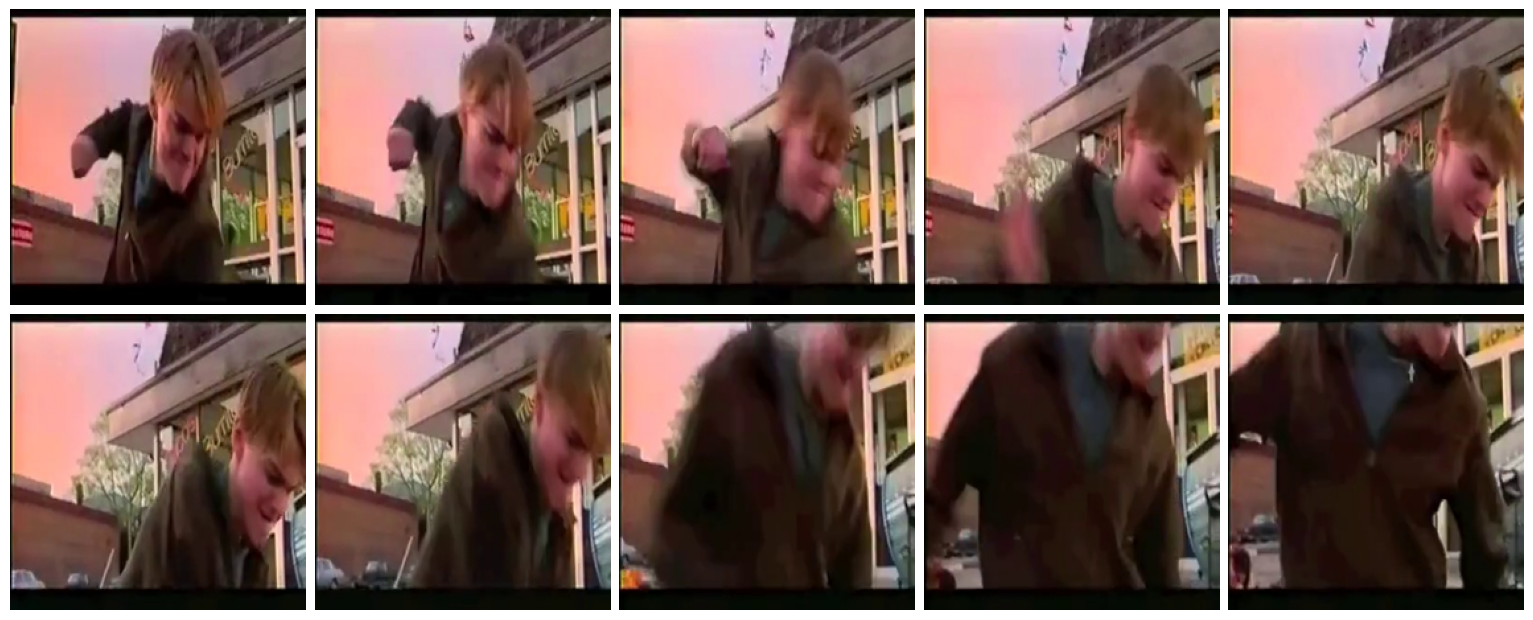

In [9]:
random.shuffle(valid)
with torch.no_grad():

    img_paths = []
    blip_res = 0
    ours_res = 0
    record = {}
    record['MSR-VTT-videoTestVideo_video9523-shot1_4'] = 1
    record['video-storytelling-videocamping_EytINruY3-U-shot44_0'] = 1
    record['open-images-2598_089d0acc79442982'] = 1
    record['video-storytelling-videocamping_dBXYM3dQTSo-shot74_1'] = 1
    record['MSR-VTT-videoTestVideo_video7698-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video8144-shot2_2'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot51_2'] = 1
    record['open-images-1524_afff5d45dcba22db'] = 1
    record['open-images-510_3a241cb30d6e5319'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot63_3'] = 1
    record['MSR-VTT-videoTestVideo_video8262-shot1_2'] = 1
    record['MSR-VTT-videoTestVideo_video7420-shot1_1'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot78_0'] = 1
    record['video-storytelling-videobirthday_fwpYnUDbusw-shot66_5'] = 1
    record['MSR-VTT-videoTestVideo_video9289-shot1_0'] = 1
    record['open-images-2629_7ebb92dea2a01abf'] = 1
    record['MSR-VTT-videoTestVideo_video8917-shot1_0'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot35_0'] = 1
    record['MSR-VTT-videoTestVideo_video8125-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video8310-shot1_5'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot63_2'] = 1
    record['video-storytelling-videowedding_de8dLXvgV-I-shot13_0'] = 1
    
    for img_dir, img_idx, text_ in valid:
        #img_dir, img_idx, text_ = find_by_text(valid,caption3)

        #if (img_dir in record):
            #continue

        if (img_dir == 'MSR-VTT-videoTestVideo_video7686-shot3_0'):
            text = [pre_caption(text_)]
            img_idx = int(img_idx)
            img_files = list((Path(img_dirs) / img_dir).glob("*.jpg"))
            img_files = sorted(img_files, key=lambda x: int(str(x).split('/')[-1].split('.')[0][3:]))
            images = [Image.open(photo_file).convert("RGB") for photo_file in img_files]
            preprocess = transforms.Compose([
                transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
                ])  
            images = [preprocess(image) for image in images]
            image = torch.stack(images).to(device)

            # Blip
            output = blip(image, text, mode='multimodal')
            logits = blip.itm_head(output[:,0,:])
            print('blip十张图的logits(第一列是不匹配的置信度，第二列是匹配的置信度):',logits)
            logits1 = torch.nn.functional.softmax(logits,dim=1)[:,1]
            
            pred1 = torch.argmax(logits1.squeeze()).squeeze()
            
            # Ours
            output = adater_blip(image, text)
            logits = adater_blip.pretrained_blip.itm_head(output[:,0,:])
            print('ours十张图的logits(第一列是不匹配的置信度，第二列是匹配的置信度):',logits)
            logits2 = torch.nn.functional.softmax(logits,dim=1)[:,1]
            pred2 = torch.argmax(logits2.squeeze()).squeeze()
            print('这两列置信度取softmax，然后取匹配的置信度作为最终分数')
            print('blip十张图片的分数分别为：',logits1)
            print('ours十张图片的分数分别为：',logits2)

            logits1 = torch.softmax(logits1,dim=0).reshape(-1)
            logits2 = torch.softmax(logits2,dim=0).reshape(-1)
            logits1 = logits1.cpu().numpy().reshape(1,-1)
            logits2 = logits2.cpu().numpy().reshape(1,-1)
            print('Blip十个分数softmax后的结果为：',logits1)
            print('Ours十个分数softmax后的结果为：',logits2)

            img_paths = img_files
            blip_res = logits1
            ours_res = logits2
            print('caption:',text_)
            print("ground truth:",img_idx,"blip:",pred1.cpu().item(),'ours:',pred2.cpu().item())

            max_element = logits2.squeeze()[pred2]
            second_max_element = 0;
            for element in logits2.squeeze():
                if element < max_element and element > second_max_element:
                    second_max_element = element
            
            diff = max_element - second_max_element

            print(img_dir)
            # if (pred2 == img_idx and pred1 != img_idx):
            #     break

fig, ax = plt.subplots(2, 5, figsize=(19.53125, 7.8125))

images = [Image.open(photo_file).convert("RGB").resize((224, 224)) for photo_file in img_paths]
for i, img in enumerate(images):
    ax[i // 5, i % 5].imshow(np.array(img))
    ax[i // 5, i % 5].axis('off')

plt.subplots_adjust(wspace=0.03, hspace=0.03)  
plt.show()


blip
[[0.1   0.099 0.103 0.099 0.099 0.099 0.099 0.105 0.099 0.099]]


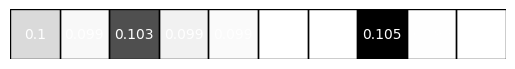

In [23]:
print('blip')
print(blip_res)
plt_logits(blip_res)

ours
[[0.145 0.129 0.105 0.086 0.09  0.083 0.084 0.085 0.105 0.089]]


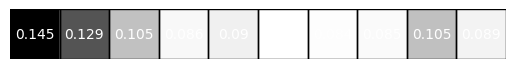

In [24]:
print('ours')
print(ours_res)
plt_logits(ours_res)

In [9]:
logits1

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)

### Case Study 想法
上面的文本存在几个判断条件，分别为"the lady in blue"、"bags were hang up"和"the transition image"
通过模型输出各图的logits，我们可以体现模型是否真正关注到这些判定信息
下面分别用三个子条件的文本进行检索，可以看到除了"the lady in blue"效果不好，另两个效果都很不错

In [13]:
subcaption1 = "Two girls in the frame."
subcaption2 = "There is an image of them swimming horizontally layered on them but is not as in focus as them standing vertically."
subcaption3 = "It's a little blurry."
subcaption4 = "the first picture having slightly more visibility than the second."
subcaption5 = "The person on the left has their mouth still closed."

In [37]:
with torch.no_grad():
    text = [pre_caption(subcaption1)]

    output = blip(image, text, mode='multimodal')
    logits = blip.itm_head(output[:,0,:])
    logits1 = torch.nn.functional.softmax(logits,dim=1)[:,1]
    pred1 = torch.argmax(logits1.squeeze()).squeeze()
    output = adater_blip(image, text)
    logits = adater_blip.pretrained_blip.itm_head(output[:,0,:])
    logits2 = torch.nn.functional.softmax(logits,dim=1)[:,1]
    pred2 = torch.argmax(logits2.squeeze()).squeeze()
    logits1 = torch.softmax(logits1,dim=0).reshape(-1)
    logits2 = torch.softmax(logits2,dim=0).reshape(-1)
    logits1 = logits1.cpu().numpy().reshape(1,-1)
    logits2 = logits2.cpu().numpy().reshape(1,-1)
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    plt_logits(logits1)
    

NameError: name 'subcaption1' is not defined

[[0.1   0.099 0.1   0.099 0.099 0.099 0.101 0.101 0.101 0.1  ]]
[[0.092 0.066 0.102 0.058 0.063 0.063 0.151 0.152 0.106 0.148]]


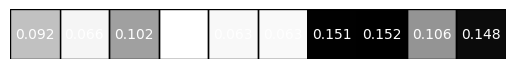

In [18]:
plt_logits(logits2)
print(logits1)
print(logits2)